### **Diplomado Programación en Python Especializado para Ingenieros - Proyecto Final**

#### **Integrantes:** 
####     - Alicia Monserrat Gali Sosa, CI: 4.597.982
#### **Título:** Cálculo de anomalías de precipitación mensual y monitoreo de sequías con índice SPI bajo el escenario de cambio climático RCP 4.5 en la Reserva del Bosque Mbaracayú.

En este trabajo se plantea la necesidad de evaluar los impactos del cambio climático en la Reserva del Bosque Mbaracayú, específicamente en los patrones de precipitación y la ocurrencia de sequías, con el fin de asistir en la planificación de estrategias para la adaptación en este remanente boscoso clave para la conservación. Para esto, se propone desarrollar un programa utilizando Python que permita evaluar los cambios en la precipitación mensual y el comportamiento de las sequías bajo el escenario de cambio climático RCP 4.5 en la reserva, mediante:

1. Cálculo de la climatología de referencia.
2. Cálculo de anomalías de precipitación.
3. Cálculo del Índice de Precipitación Estandarizado (SPI) a corto plazo (3 meses) y largo plazo (12 meses).
4. Cálculo de métricas de sequías: cantidad de eventos de sequía, duración media y severidad media.
5. Breve análisis de tendencia.


**Obs:** El escenario RCP 4.5 es un modelo de cambio climático que proyecta un futuro con emisiones moderadas de gases de efecto invernadero (GEI) y que asume que las políticas de mitigación logran estabilizar las concentraciones de CO₂ antes de 2100.

#### 1. Preparación de los datos:

In [19]:
'''
Se instalan las bibliotecas climate-indices y pymannkendall en caso de no contar con ellas.
climate-indices se utilizará para el cálculo del SPI
pymannkendall se utilizará para el análisis de tendencia del SPI
'''
#%pip install climate-indices
#%pip install pymannkendall

'\nSe instalan las bibliotecas climate-indices y pymannkendall en caso de no contar con ellas.\nclimate-indices se utilizará para el cálculo del SPI\npymannkendall se utilizará para el análisis de tendencia del SPI\n'

In [20]:
'''
Importación de bibliotecas necesarias (pandas, numpy, matplotlib, seaborn, climate_indices, pymannkendall)
Carga de archivos CSV históricos (1961–2005) y proyectados (2006–2099).
Conversión columnas de fecha a formato datetime.
Verificación y tratamiento de valores faltantes. Limpieza de los df y estandarización de nombres.
Creación de columnas auxiliares
'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_indices import compute, indices
import pymannkendall as mk

In [21]:
'''
Filtramos las planillas .csv que contienen los datos históricos y proyectados por la coordenada 
correspondiente a la Reserva del Bosque Mbaracayú:
Latitud: -24.2
Longitud: -55.4
Además, eliminamos la columna 'Hora' del df, ya que no será utilizado, y renombramos las columnas
'Data', 'Latitude', 'Longitude' y 'PREC', como 'Fecha', 'Latitud', 'Longitud' y 'Precipitacion'
de manera a tener los nombres de las columnas estandarizados tanto para el Data Frame histórico 
como para el proyectado.
'''
historico = pd.read_csv('BESM_HISTORICO_PREC_1961_2005_PY.csv')
historico = historico[(historico['Latitude'] == -24.2) & (historico['Longitude'] == -55.4)]
historico.drop(['Hora'], axis=1, inplace=True)
historico.rename(columns = {
    'Data': 'Fecha',
    'Latitude': 'Latitud',
    'Longitude': 'Longitud',
    'PREC': 'Precipitacion'
}, inplace=True)

historico

,Fecha,Latitud,Longitud,Precipitacion
188467,1961/01/01,-24.2,-55.4,83.587234
188492,1961/02/01,-24.2,-55.4,174.544586
188513,1961/03/01,-24.2,-55.4,257.097473
188533,1961/04/01,-24.2,-55.4,77.487198
188553,1961/05/01,-24.2,-55.4,140.717438
...,...,...,...,...
199702,2005/08/01,-24.2,-55.4,96.175758
199726,2005/09/01,-24.2,-55.4,103.833183
199746,2005/10/01,-24.2,-55.4,240.889313
199769,2005/11/01,-24.2,-55.4,117.583977


In [22]:
'''
Se convierte la columna 'Fecha' a formato datetime y luego se la define como el index del Data Frame
 y se crean además las columnas auxiliares de 'Año' y 'Mes'.
'''

historico['Fecha'] = pd.to_datetime(historico['Fecha'])
historico = historico.set_index(['Fecha'])
historico['Año'] = historico.index.year
historico['Mes'] = historico.index.month
historico

,Latitud,Longitud,Precipitacion,Año,Mes
Fecha,,,,,
1961-01-01,-24.2,-55.4,83.587234,1961,1
1961-02-01,-24.2,-55.4,174.544586,1961,2
1961-03-01,-24.2,-55.4,257.097473,1961,3
1961-04-01,-24.2,-55.4,77.487198,1961,4
1961-05-01,-24.2,-55.4,140.717438,1961,5
...,...,...,...,...,...
2005-08-01,-24.2,-55.4,96.175758,2005,8
2005-09-01,-24.2,-55.4,103.833183,2005,9
2005-10-01,-24.2,-55.4,240.889313,2005,10


In [23]:
'''
Se aplica el mismo filtro realizado para el Data Frame 'historico', en donde solo se conservan las filas con:
Latitud: -24.2
Longitud: -55.4
Y se renombra la columna 'PREC' como 'Precipitacion', ahora ya se tienen ambos Data Frame con columnas del mismo
nombre.
De igual manera, se convierte la columna 'Fecha' a formato datetime, se asigna la columna 'Fecha' como 
el index del Data Frame proyectado, y se crean las columnas auxiliares 'Año' y 'Mes'
'''
proyectado = pd.read_csv('BESM_RCP45_PREC_2006_2099_PY.csv')
proyectado = proyectado[(proyectado['Latitud'] == -24.2) & (proyectado['Longitud'] == -55.4)]
proyectado.rename(columns={'PREC': 'Precipitacion'}, inplace=True)
proyectado['Fecha'] = pd.to_datetime(proyectado['Fecha'])
proyectado = proyectado.set_index(['Fecha'])
proyectado['Año'] = proyectado.index.year
proyectado['Mes'] = proyectado.index.month
proyectado

,Latitud,Longitud,Precipitacion,Año,Mes
Fecha,,,,,
2006-01-01,-24.2,-55.4,154.817688,2006,1
2006-02-01,-24.2,-55.4,60.253784,2006,2
2006-03-01,-24.2,-55.4,118.251221,2006,3
2006-04-01,-24.2,-55.4,19.395882,2006,4
2006-05-01,-24.2,-55.4,185.284836,2006,5
...,...,...,...,...,...
2099-11-01,-24.2,-55.4,109.480904,2099,11
2099-12-01,-24.2,-55.4,212.509918,2099,12
2008-03-01,-24.2,-55.4,84.142548,2008,3


In [24]:
# Se crea una función para evaluar si existen valores nulos en la columna
# 'Precipitacion' y eliminar esos registros

def eliminar_nulos(df):
    if df['Precipitacion'].isna().any():
        print('La columna "Precipitacion" presenta valores nulos que serán eliminados.')
        df = df.dropna(subset=['Precipitacion'])
    else:
        print('No hay valores nulos en la columna Precipitacion.')
    return df

print('Data Frame "Historico":')
historico = eliminar_nulos(historico)

print('\n')
print('Data Frame "Proyectado":')
proyectado = eliminar_nulos(proyectado)

Data Frame "Historico":
No hay valores nulos en la columna Precipitacion.


Data Frame "Proyectado":
No hay valores nulos en la columna Precipitacion.


#### 2. Cálculo de la climatología de referencia (1961 - 2005):

In [25]:
# Se agrupan los datos por mes y se calcula la media histórica mensual de precipitación.
climatologia= historico.groupby('Mes')['Precipitacion'].mean()
climatologia.name = 'Climatologia de ref'
climatologia


Mes
1     157.403045
2     142.200890
3     103.422771
4      83.304851
5      74.924938
6      54.621992
7      79.170357
8     102.462602
9      96.813126
10    138.847857
11    154.310230
12    157.135363
Name: Climatologia de ref, dtype: float64

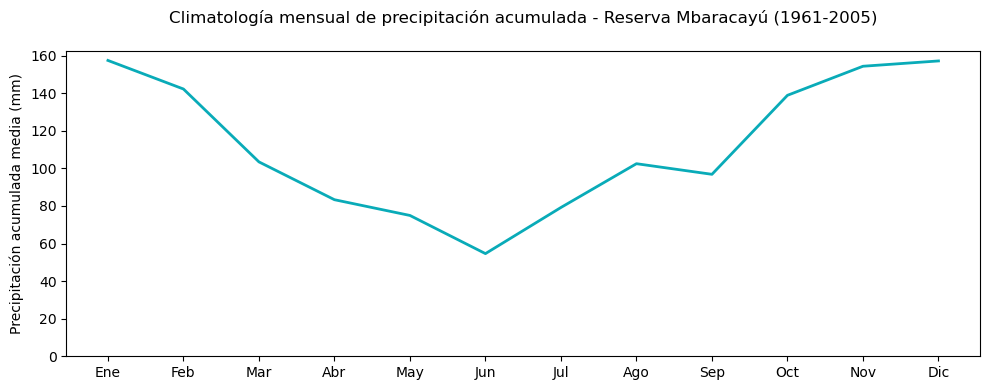

In [26]:
# Gráfico de la climatología de referencia
fig_climatologia, ax_climatologia = plt.subplots(figsize=(10,4))

sns.lineplot(
    x=climatologia.index,
    y=climatologia.values,
    color='#09ABB8',
    linewidth=2,
    ax=ax_climatologia
)

ax_climatologia.set_xlabel('')
ax_climatologia.set_ylabel('Precipitación acumulada media (mm)')
ax_climatologia.set_title('Climatología mensual de precipitación acumulada - Reserva Mbaracayú (1961-2005)', pad=20)

max_val = climatologia.values.max()
ax_climatologia.set_yticks(np.arange(0, max_val + 20, 20))
ax_climatologia.set_xticks(np.arange(1,13))
ax_climatologia.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])

plt.tight_layout()
plt.show()

# Creamos primero una carpeta en la cual almacenaremos los principales resultados
os.makedirs('resultados', exist_ok=True)

fig_climatologia.savefig('resultados/climatologia_ref.png', dpi=150, bbox_inches='tight')



El gráfico muestra el comportamiento típico del clima en Paraguay, con las estaciones más calurosas como la primavera y el verano con mayor humedad (más precipitación) y las estaciones de otoño e invierno como las estaciones secas de menor precipitación.

#### 3. Cálculo de anomalías de precipitación mensual:

In [39]:
'''
Las anomalías de precipitación mensual consisten en la diferencia entre la precipitación proyectada
bajo el escenario de cambio climático analizado y la climatología de precipitación (histórico).
Debido a que la planificación de las medidas de adaptación se diseñan teniendo en cuenta los
impactos del cambio climático en el corto, mediano y largo plazo, primero se definen
los intervalos para estas tres ventanas de la siguiente manera:

- Corto plazo: 2021–2040
- Mediano plazo: 2041–2070
- Largo plazo: 2071–2099

'''

ventanas = {
    'Corto plazo (2021-2040)': (2021, 2040),
    'Mediano plazo (2041-2070)': (2041, 2070),
    'Largo plazo (2071-2099)': (2071, 2099)
}

# Luego se calcula el promedio mensual de anomalías para cada ventana,
# para esto creamos un diccionario para almacenar anomalías por ventana
anom_dict = {}

# Y utilizamos un for para calcular las anomalías en el corto, mediano y largo plazo
# y almacenarlas en el diccionario anom_dict
for nombre, (inicio, fin) in ventanas.items():
    df_ventana = proyectado[(proyectado['Año'] >= inicio) & (proyectado['Año'] <= fin)]
    media_mensual = df_ventana.groupby('Mes')['Precipitacion'].mean()
    anom_dict[nombre] = media_mensual - climatologia

# Finalmente, convertimos el diccionario al Data Frame 'anomalias'
anomalias = pd.DataFrame(anom_dict)

# Exportamos el df con el resumen de análisis de sequías en caso de que quieran visualizarle en una planilla
anomalias.to_csv('resultados/anomalias.csv', sep=';')
anomalias

,Corto plazo (2021-2040),Mediano plazo (2041-2070),Largo plazo (2071-2099)
Mes,,,
1,-65.405273,-57.879001,-51.965078
2,-67.675769,-48.728869,-44.186310
3,-40.540725,-40.505592,-36.072861
4,-12.283461,-16.097498,-12.474770
5,28.775674,22.889224,45.986538
6,41.479542,30.106092,35.178919
7,-3.992518,7.995466,2.753342
8,-52.575610,-41.367219,-25.744547
9,-25.041460,-18.049442,-21.278686


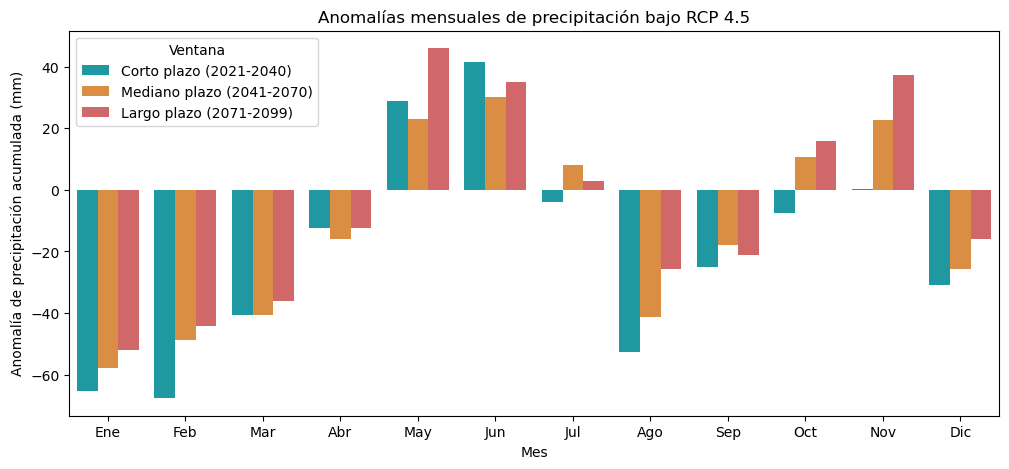

In [28]:
'''
Se representarán las anomalías en un gráfico de barras comparativo entre las tres ventanas
seleccionadas, de manera a visualizar cómo las anomalías de precipitación acumulada mensual
variarán en el corto, mediano y largo plazo.
'''

# Se prepara el df para seaborn (long format)
anom_long = anomalias.reset_index().melt(id_vars='Mes', 
                                         value_vars=anomalias.columns, 
                                         var_name='Ventana', 
                                         value_name='Anomalia')

fig_anom, ax_anom = plt.subplots(figsize=(12,5))
sns.barplot(x='Mes', y='Anomalia', hue='Ventana', data=anom_long, palette=['#09ABB8','#F28E2B','#E15759'], ax=ax_anom)

ax_anom.set_xlabel('Mes')
ax_anom.set_ylabel('Anomalía de precipitación acumulada (mm)')
ax_anom.set_title('Anomalías mensuales de precipitación bajo RCP 4.5')
ax_anom.set_xticks(np.arange(0,12))
ax_anom.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
ax_anom.legend(title='Ventana')

plt.show()
fig_anom.savefig('resultados/anom_men_precip_por_ventana.png', dpi=150, bbox_inches='tight')


Haciendo un análisis rápido de las anomalías de precipitación bajo el modelo BESM y el escenario RCP 4.5 observamos lo siguiente:

- En las tres ventanas (corto, mediano y largo plazo) vemos en general un patrón de disminución marcada de la precipitación en la temporada de lluviosa (Diciembre a Marzo) y un patrón de aumento de la precipitación en los inicios de la temporada seca y de reducción a finales de la misma.

#### 4. Cálculo del SPI (Standardized Precipitation Index):

El **Índice de Precipitación Estandarizado (SPI)** se calcula acumulando primero la precipitación durante un período específico, como 1, 3 o 12 meses.  

A continuación, se ajusta una distribución de probabilidad, generalmente la distribución gamma (y la utilizada en este trabajo), a estos datos acumulados para transformarlos en una distribución normal estándar (equivalente a la gaussiana).  

El valor final adimensional del SPI se determina comparando la precipitación observada con el promedio a largo plazo, mediante la fórmula:  

SPI=(P-P*)/σp

Donde:  
- P: es la precipitación observada.  
- P*: es la precipitación media.  
- σp: es la desviación estándar.  

El SPI indica cómo se desvía la precipitación del promedio climatológico durante un período de acumulación determinado.  
Este indicador es adecuado y se utiliza comúnmente para detectar y caracterizar la sequía meteorológica.  

Para cualquier región, un déficit de precipitación cada vez más severo (es decir, sequías meteorológicas) se manifiesta cuando el SPI disminuye por debajo de **–1,0**, mientras que un exceso de precipitación cada vez más severo se manifiesta cuando el SPI aumenta por encima de **1,0**.


In [40]:
'''
En este trabajo, se calcula el SPI-3 con el fin de evaluar sequías meteorológicas o estacionales
(pueden ser de mayor relevancia en el caso que se esten evaluando tierras agrícolas) y el SPI-12 
con el fin de evaluar sequías hidrológicas o de balance anual.
'''
# Se ordenan los df por fechas
historico = historico.sort_values('Fecha')
proyectado = proyectado.sort_values('Fecha')

# Rolling sums. Aquí se calculan las precipitaciones acumuladas para cada mes para el intervalo de 3 y de 12 meses.
historico['P3'] = historico['Precipitacion'].rolling(window=3).sum()
historico['P12'] = historico['Precipitacion'].rolling(window=12).sum()
proyectado['P3'] = proyectado['Precipitacion'].rolling(window=3).sum()
proyectado['P12'] = proyectado['Precipitacion'].rolling(window=12).sum()

# Se define la función para calcular el SPI utilizando la biblioteca climate_indices
def calcular_spi(df, col, escala):
    serie = df[col].to_numpy()

    spi = indices.spi(
        values=serie,
        scale=escala,   # La escala es 3 o 12, según estemos calculando SPI-3 o SPI-12
        distribution=indices.Distribution.gamma,
        data_start_year=df.index.year.min(),
        calibration_year_initial=1961,
        calibration_year_final=2005,
        periodicity= compute.Periodicity.monthly
    )

    return pd.Series(spi, index=df.index)

# Se calcula el SPI-3 y SPI-12 aplicando la función definida a la proyección
spi3 = calcular_spi(proyectado, 'Precipitacion', 3)
spi12 = calcular_spi(proyectado, 'Precipitacion', 12)

proyectado['SPI-3'] = spi3
proyectado['SPI-12'] = spi12

# Exportamos el df proyectado con los resultados en caso de que quieran visualizarle en una planilla
proyectado.to_csv('resultados/proyectado.csv', sep=';')
proyectado

,Latitud,Longitud,Precipitacion,Año,Mes,P3,P12,SPI-3,SPI-12
Fecha,,,,,,,,,
2006-01-01,-24.2,-55.4,154.817688,2006,1,NaN,NaN,NaN,NaN
2006-02-01,-24.2,-55.4,60.253784,2006,2,NaN,NaN,NaN,NaN
2006-03-01,-24.2,-55.4,118.251221,2006,3,333.322693,NaN,1.248688,NaN
2006-04-01,-24.2,-55.4,19.395882,2006,4,197.900887,NaN,-0.323054,NaN
2006-05-01,-24.2,-55.4,185.284836,2006,5,322.931938,NaN,1.036273,NaN
...,...,...,...,...,...,...,...,...,...
2099-08-01,-24.2,-55.4,143.985367,2099,8,200.190303,1687.651958,-0.312945,2.226602
2099-09-01,-24.2,-55.4,67.329437,2099,9,264.038887,1589.457484,0.591942,1.864386
2099-10-01,-24.2,-55.4,283.722321,2099,10,495.037125,1654.670512,1.806847,1.998238


In [ ]:
# Se filtra el SPI para considerar solo los años de interés (2021 a 2099)
spi_filtrado = proyectado.loc[proyectado.index.year >= 2021].copy()

# Se calcula el SPI-3 y SPI-12 por ventana, promediado por mes
# Se crea un df vacío para guardar los resultados
meses = range(1,13)
spi_promedios = []

for ventana, (inicio, fin) in ventanas.items():
    mask = (spi_filtrado.index.year >= inicio) & (spi_filtrado.index.year <= fin)
    subset = spi_filtrado.loc[mask]
    for mes in meses:
        mask_mes = subset.index.month == mes
        spi_promedios.append({
            'Mes': mes,
            'Ventana': ventana,
            'SPI-3': subset.loc[mask_mes, 'SPI-3'].mean(),
            'SPI-12': subset.loc[mask_mes, 'SPI-12'].mean()
        })

spi_promedios = pd.DataFrame(spi_promedios)

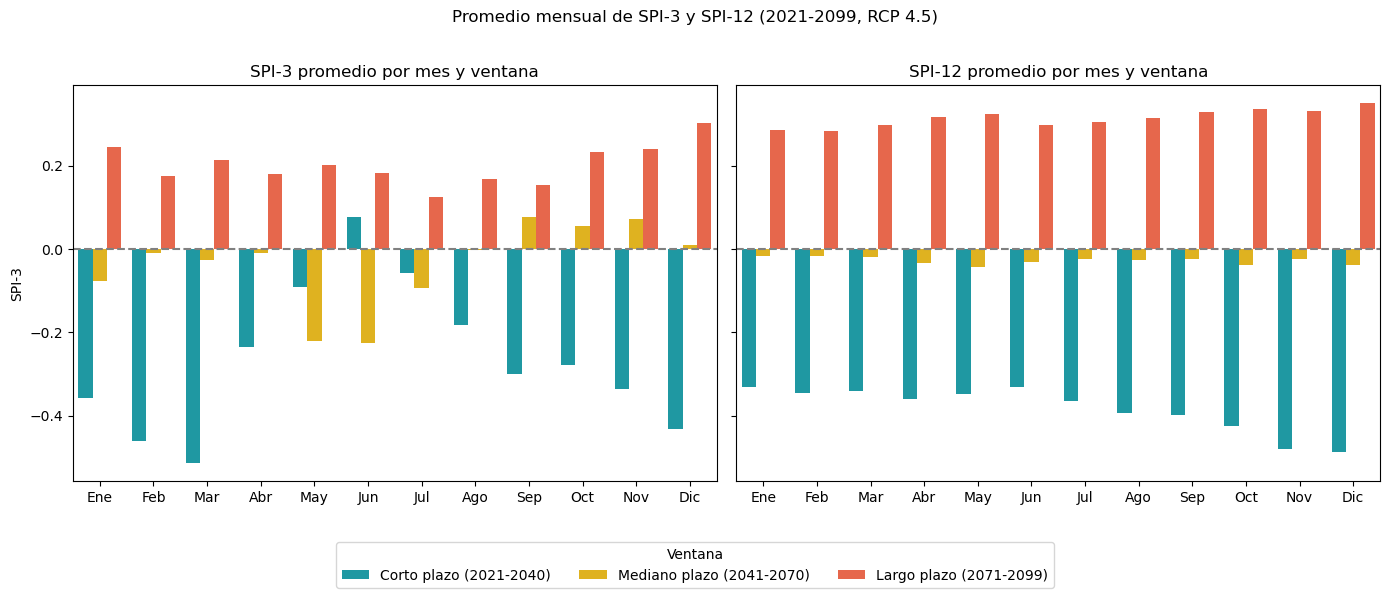

In [ ]:
# Etiquetas de meses
mes_labels = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
spi_promedios['Mes_label'] = spi_promedios['Mes'].apply(lambda x: mes_labels[x-1])

fig_spi, axes_spi = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# SPI-3
sns.barplot(
    data=spi_promedios,
    x='Mes_label',
    y='SPI-3',
    hue='Ventana',
    palette=['#09ABB8', '#FFC300', '#FF5733'],
    ax=axes_spi[0]
)
axes_spi[0].axhline(0, color='gray', linestyle='--')
axes_spi[0].set_title('SPI-3 promedio por mes y ventana')
axes_spi[0].set_xlabel('')
axes_spi[0].set_ylabel('SPI-3')

# SPI-12
sns.barplot(
    data=spi_promedios,
    x='Mes_label',
    y='SPI-12',
    hue='Ventana',
    palette=['#09ABB8', '#FFC300', '#FF5733'],
    ax=axes_spi[1]
)
axes_spi[1].axhline(0, color='gray', linestyle='--')
axes_spi[1].set_title('SPI-12 promedio por mes y ventana')
axes_spi[1].set_xlabel('')
axes_spi[1].set_ylabel('SPI-12')

# Se define la leyenda y se austa el layout
axes_spi[0].legend_.remove()
axes_spi[1].legend_.remove()
handles, labels = axes_spi[0].get_legend_handles_labels()
fig_spi.legend(handles, labels, title='Ventana', loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))

plt.subplots_adjust(bottom=0.25)
plt.suptitle('Promedio mensual de SPI-3 y SPI-12 (2021-2099, RCP 4.5)', y=1.02)
plt.tight_layout()
plt.show()
fig_spi.savefig('resultados/spi_3_12_prom_men_por_ventana.png', dpi=150, bbox_inches='tight')


Los gráficos de SPI-3 y SPI-12 promedio por mes y ventana muestran en general un comportamiento bastante similar, en donde observamos SPI's negativos indicando condiciones más secas en el corto y mediano plazo, pero que luego en la ventana de largo plazo aumentan a valores positivos indicando condiciones más húmedas en la reserva.

Un aspecto notable es como en el SPI-12 los valores por mes se encuentran bastante estabilizados, esto debido a que el SPI-12 de cada mes considera la precipitación acumulada de un año, por lo que la variación de mes a mes se suaviza bastante.

Por otro lado, el SPI-3 permite notar patrones temporales más interesantes, especialmente en el corto plazo en el que nuevamente la temporada lluviosa (ver climatología de referencia) presenta en promedio valores de SPI-3 más bajos, indicando condiciones más secas de lo normal en esta temporada. Por otro lado, en el mediano plazo por el contrario, vemos valores más bajos de SPI-3 en promedio en la temporada seca, lo cual acrecentaría estas condiciones.

Para un área silvestre protegida esto puede tener varios efectos:

1.	Estrés hídrico en ecosistemas acuáticos y terrestres:

    - Menor precipitación en la temporada húmeda podría reducir el caudal de ríos, arroyos y lagunas temporales.
    - Esto afecta a peces, anfibios y otras especies dependientes de cuerpos de agua permanentes o estacionales.
2.	Alteración de la fenología vegetal

    - Plantas que dependen de lluvias abundantes en diciembre-marzo podrían florecer o germinar menos, afectando la regeneración natural.
    - Especies que dependen de frutos o semillas de esas plantas podrían sufrir disminución de alimento.

3.	Mayor riesgo de sequías y mortalidad de fauna
    - Menor agua disponible y alimentos menos abundantes aumentan la mortalidad de animales y el estrés de los ecosistemas.

4.	Mayor riesgo de incendios forestales
    - Menos lluvia en la temporada húmeda y aumento de sequedad en la temporada seca hace que la vegetación se vuelva más inflamable.

5.	Impacto en servicios ecosistémicos
    - Regulación hídrica, captura de carbono y protección de suelos pueden verse comprometidos si los patrones de precipitación cambian.


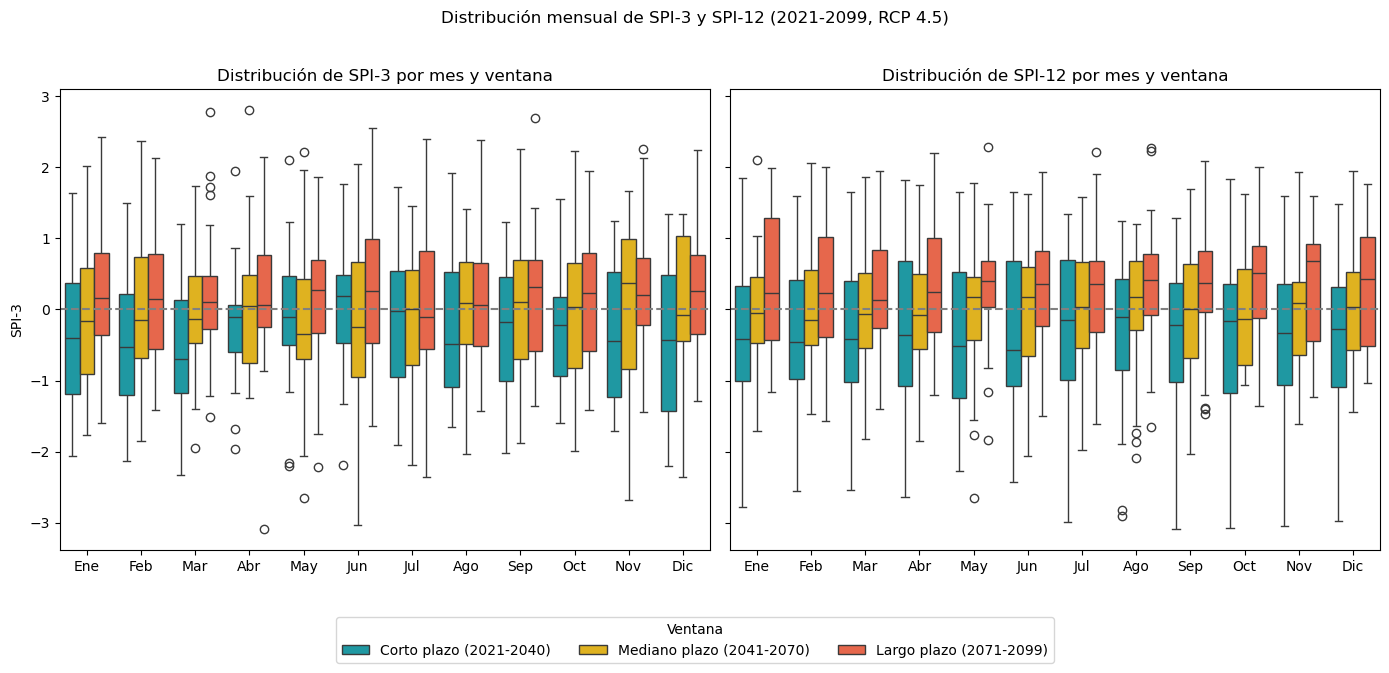

In [32]:
fig_box, axes_box = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# SPI-3
sns.boxplot(
    data=spi_filtrado,
    x=spi_filtrado.index.month,
    y='SPI-3',
    hue=pd.cut(spi_filtrado.index.year, bins=[2020,2040,2070,2099], labels=list(ventanas.keys())),
    palette=['#09ABB8', '#FFC300', '#FF5733'],
    ax=axes_box[0]
)
axes_box[0].axhline(0, color='gray', linestyle='--')
axes_box[0].set_title('Distribución de SPI-3 por mes y ventana')
axes_box[0].set_xlabel('')
axes_box[0].set_ylabel('SPI-3')
axes_box[0].set_xticks(range(0,12))
axes_box[0].set_xticklabels(mes_labels)
axes_box[0].legend_.remove()

# SPI-12
sns.boxplot(
    data=spi_filtrado,
    x=spi_filtrado.index.month,
    y='SPI-12',
    hue=pd.cut(spi_filtrado.index.year, bins=[2020,2040,2070,2099], labels=list(ventanas.keys())),
    palette=['#09ABB8', '#FFC300', '#FF5733'],
    ax=axes_box[1]
)
axes_box[1].axhline(0, color='gray', linestyle='--')
axes_box[1].set_title('Distribución de SPI-12 por mes y ventana')
axes_box[1].set_xlabel('')
axes_box[1].set_ylabel('SPI-12')
axes_box[1].set_xticks(range(0,12))
axes_box[1].set_xticklabels(mes_labels)
axes_box[1].legend_.remove()

handles, labels = axes_box[0].get_legend_handles_labels()
fig_box.legend(handles, labels, title='Ventana', loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08))

plt.suptitle('Distribución mensual de SPI-3 y SPI-12 (2021-2099, RCP 4.5)', y=1.02)
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()
fig_box.savefig('resultados/spi_3_12_boxplot_por_ventana.png', dpi=150, bbox_inches='tight')


En el gráfico comparativo de boxplots para el SPI-3 y SPI-12 por mes y por ventana se puede observar lo siguiente:

- Prácticamente en todos los casos (a excepción del mes de Junio para el SPI-3) observamos que las medianas del SPI corresponden a valores negativos entre 0 y -1 para el corto plazo, confirmando nuevamente las condiciones más secas observadas en esta ventana en análisis anteriores.

- En el corto plazo, los valores extremos negativos de SPI-3 y SPI-12 están entre -1 y -3, indicando valores de sequía desde moderada (< -1), hasta extrema (< -2). Si bien también se observan valores de SPI entre +1 y +2, la mayor cantidad de valores en el corto plazo son negativos, por lo que se asume que estos no tuvieron mucha incidencia.

- En el mediano plazo se ven condiciones más equilibradas y cercanas a 0, sin tomar en general valores de SPI que señalen una humedad ni sequía marcada.

- En el largo plazo por el contrario, observamos en casi todos los meses (a excepción del mes de Julio para el SPI-3), una mediana de los SPI localizada siempre hacia los valores positivos, lo cual indica nuevamente mayor precipitación y condiciones más húmedas en el largo plazo que ya fueron observadas anteriormente.

- Los bigotes largos indican que los valores extremos (tanto positivos como negativos) se alejan bastante de la mediana, lo cual podría estar señalando una alta variabilidad interanual. Esto puede significar que algunos años serán muy húmedos y otros muy secos, es decir, podría haber una gran irregularidad en la precipitación.

- Se observan bastantes outliers, lo cual podría indicar que aumentarán los eventos extremos como sequías muy severas o altas precipitaciones. El SPI-3 refleja sequías de corto plazo, mientras que el SPI-12 refleja sequías de largo plazo o acumuladas. Debido a que ambos muestran outliers en el corto plazo (2021-2040), esto podría indicar que tanto episodios de sequía breves como prolongados podrían suceder en esta ventana. Por otro lado, también se observa una cantidad llamativa de outliers en el SPI-3 y SPI-12 en el largo plazo, lo podría indicar eventos de precipitación extremadamente alta. En el caso del SPI-3 esto podría interpretarse como picos de lluvias cortas e intensas, mientras que en el caso del SPI-12 estos indicarían años o periodos muy húmedos acumulados. Cabe resaltar que esto podría llevar a impactos adversos en el largo plazo como inundaciones locales o sobrecarga de ecosistemas si las lluvias son demasiado intensas en poco tiempo o a fenómenos de erosión hídrica del suelo.

#### 5. Análisis de sequías mediante métricas:

Los eventos de sequía se evaluarán a partir de tres métricas: número de eventos, duración media y severidad media. Esto se evaluará para cada ventana de corto, mediano y largo plazo.

- **Cantidad de eventos de sequía:** número de periodos consecutivos bajo el umbral de SPI -1.

- **Duración media:** promedio de meses que dura cada evento.

- **Severidad media:** suma de los valores de SPI (en magnitud) durante cada evento, promediada sobre todos los eventos.

In [33]:
# Primeramente, se calcula el SPI-3 y SPI-12 para el histórico, ya que es necesario para comparar
# cómo varían las métricas de sequía en el clima proyectado
historico = historico.sort_values('Fecha')
historico['P3'] = historico['Precipitacion'].rolling(window=3).sum()
historico['P12'] = historico['Precipitacion'].rolling(window=12).sum()

historico['SPI-3'] = calcular_spi(historico, 'Precipitacion', 3)
historico['SPI-12'] = calcular_spi(historico, 'Precipitacion', 12)

# Exportamos el df historico con los resultados en caso de que quieran visualizarle en una planilla
historico.to_csv('resultados/historico.csv', sep=';')

In [34]:
'''
Función para detectar eventos de sequía en base al SPI que retorna cantidad de eventos 
de sequía, duración media y severidad media.
'''
def eventos_sequia(spi_series, umbral=-1.0): # se considera que un evento corresponde a sequía si el SPI <= -1.0
    eventos = [] # lista en donde se guardan los eventos detectados
    duracion = 0 # cuenta cuántos meses seguidos duró el evento
    severidad = 0.0 # acumula la suma de los valores SPI durante ese evento (mientras más negativo, más severidad)
    en_evento = False # 'flag' que indica si se está dentro de un evento de sequía o no

    for v in spi_series:
        if v <= umbral:
            '''
            Si no estábamos en un evento de sequía ese evento se registra,
            si ya estábamos en uno ese evento continúa y aumenta en duración y severidad.
            '''
            if not en_evento:
                en_evento = True
                duracion = 1
                severidad = v
            else:
                duracion += 1
                severidad += v
        else:
            '''
            Caso en que se salga de un evento de sequía
            '''
            if en_evento:
                eventos.append({'duracion': duracion, 'severidad': severidad})
                en_evento = False
                duracion = 0
                severidad = 0.0
    '''
    Caso especial en que el último mes también sea una sequía (si la serie termina en medio de una sequía)
    '''
    if en_evento:
        eventos.append({'duracion': duracion, 'severidad': severidad})

    if len(eventos) == 0:
        return 0, 0.0, 0.0

    duraciones = [e['duracion'] for e in eventos]
    severidades = [e['severidad'] for e in eventos]
    dur_media = np.mean(duraciones)
    sev_media = np.mean(severidades)

    return len(eventos), dur_media, sev_media

In [41]:
# Resumen de eventos de sequía
resumen_sequia = []

# Para el histórico
for spi in ['SPI-3', 'SPI-12']:
    n, dur, sev = eventos_sequia(historico[spi])
    resumen_sequia.append({
        'Serie': 'Histórico',
        'SPI': spi,
        'Eventos': n,
        'Duración media (meses)': dur,
        'Severidad media': sev
    })

# Para el proyectado por ventana
for ventana, (inicio, fin) in ventanas.items():
    mask = (proyectado.index.year >= inicio) & (proyectado.index.year <= fin)
    subset = proyectado.loc[mask]
    for spi in ['SPI-3', 'SPI-12']:
        n, dur, sev = eventos_sequia(subset[spi])
        resumen_sequia.append({
            'Serie': ventana,
            'SPI': spi,
            'Eventos': n,
            'Duración media (meses)': dur,
            'Severidad media': sev
        })

resumen_sequia_df = pd.DataFrame(resumen_sequia)

# Exportamos el df con el resumen de análisis de sequías en caso de que quieran visualizarle en una planilla
resumen_sequia_df.to_csv('resultados/resumen_sequia.csv', sep=';')
resumen_sequia_df

,Serie,SPI,Eventos,Duración media (meses),Severidad media
0,Histórico,SPI-3,39,2.076923,-3.095554
1,Histórico,SPI-12,19,4.736842,-6.236207
2,Corto plazo (2021-2040),SPI-3,21,2.904762,-4.486773
3,Corto plazo (2021-2040),SPI-12,7,9.714286,-17.843243
4,Mediano plazo (2041-2070),SPI-3,31,1.870968,-2.833415
5,Mediano plazo (2041-2070),SPI-12,14,3.428571,-4.997079
6,Largo plazo (2071-2099),SPI-3,21,1.619048,-2.238398
7,Largo plazo (2071-2099),SPI-12,9,4.111111,-5.149601


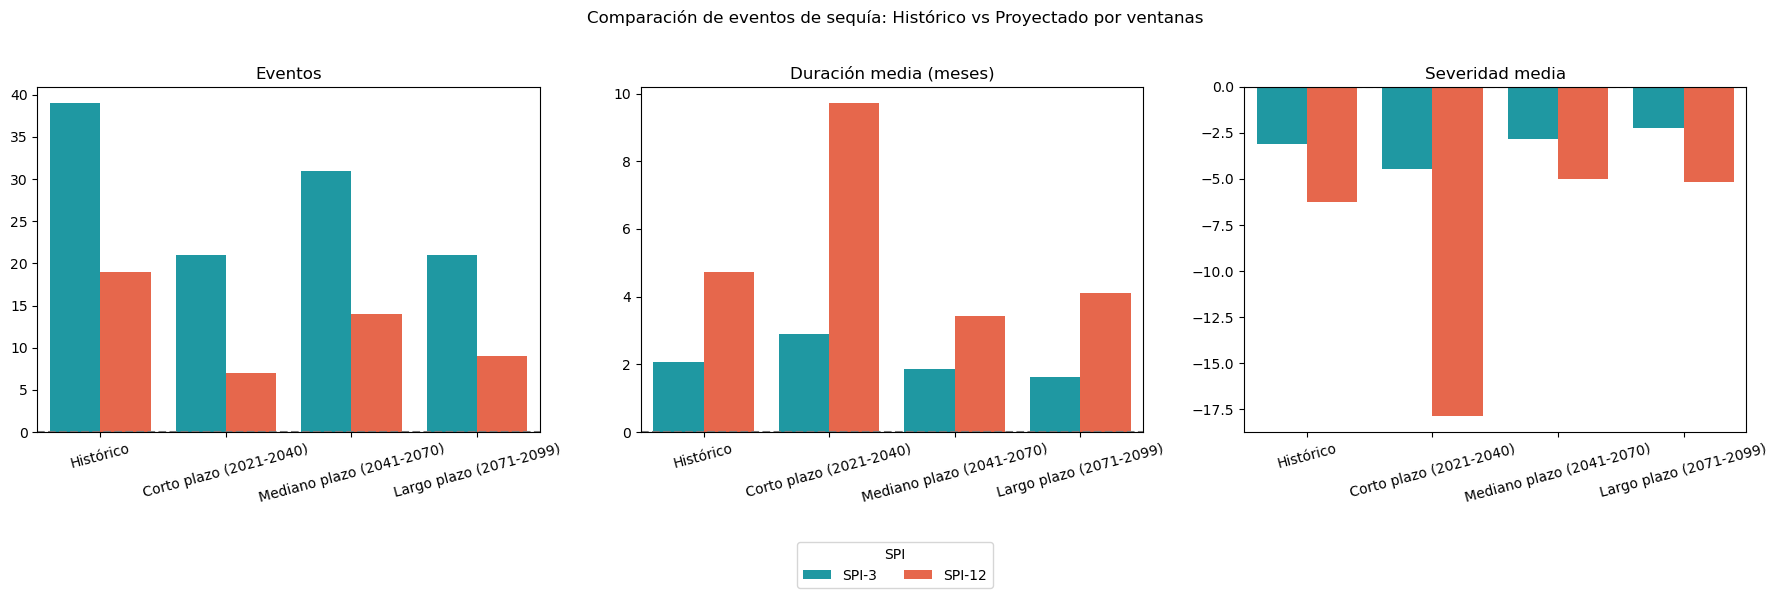

In [36]:
df_plot = resumen_sequia_df.melt(
    id_vars=['Serie', 'SPI'],
    value_vars=['Eventos', 'Duración media (meses)', 'Severidad media'],
    var_name='Métrica',
    value_name='Valor'
)

palette_spi = {'SPI-3': '#09ABB8', 'SPI-12': '#FF5733'}

fig_sequia, axes_sequia = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metrica in enumerate(df_plot['Métrica'].unique()):
    ax = axes_sequia[i]
    sns.barplot(
        data=df_plot[df_plot['Métrica'] == metrica],
        x='Serie',
        y='Valor',
        hue='SPI',
        palette=palette_spi,
        ax=ax
    )
    ax.set_title(metrica)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.axhline(0, color='gray', linestyle='--')
    ax.tick_params(axis='x', rotation=15)

axes_sequia[0].legend_.remove()
axes_sequia[1].legend_.remove()
axes_sequia[2].legend_.remove()

plt.suptitle('Comparación de eventos de sequía: Histórico vs Proyectado por ventanas', y=1.02)

handles, labels = axes_sequia[0].get_legend_handles_labels()
fig_sequia.legend(handles, labels, title='SPI', loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()
fig_sequia.savefig('resultados/analisis_sequias.png', dpi=150, bbox_inches='tight')


**- Cantidad de eventos:**

Un aspecto positivo para la Reserva del Mbaracayú es que la cantidad de eventos de sequía disminuirá bajo este escenario respecto a la climatología de referencia, tanto para las sequías meteorológicas o agrícolas (SPI-3), como para las sequías hidrológicas o de balance anual (SPI-12).

**- Duración media:**

En el corto plazo (2021-2040) se observa un considerable aumento de la duración media de sequías de larga duración (SPI-12), llegando aproximadamente a 10 meses en promedio en el que el SPI-12 se mantiene con valores por debajo de -1. Esto puede traer graves consecuencias en el balance hídrico de la reserva, la vegetación, menor agua disponible para la fauna, pudiendo incluso implicar mortandad de ciertas especies, impacto en la provisión de servicios ecosistémicos y mayor riesgo de incendios bajo estas condiciones más secas.

**- Severidad media:**

Nuevamente, resulta evidente que los mayores impactos del cambio climático en la reserva se darán al corto plazo, en donde se observa una mayor severidad en los fenómenos de sequía que ocurran durante este periodo.

#### 6. Análisis de tendencia:

El test de Mann-Kendall (MK) es una prueba no paramétrica que se usa para detectar tendencias monótonas (crecientes o decrecientes) en una serie temporal, sin asumir normalidad ni linealidad.

El test compara cada valor de la serie con los valores posteriores y cuenta cuántas veces la secuencia aumenta o disminuye. A partir de eso calcula un estadístico S, que indica la dirección (positiva o negativa), y un valor p que indica si la tendencia es estadísticamente significativa.

En este trabajo se aplicará el test de Mann-Kendall al SPI-12 histórico y proyectado con el fin de evaluar si existe una tendencia de aumento o disminución de este índice a lo largo del periodo de tiempo analizado (2021-2099), y por ende, si se tendrá una tendencia de condiciones más secas o húmedas bajo el escenario RCP 4.5. El mismo test se aplica al histórico ya que todo análisis de cambio climático debe ser comparado con la climatología.

Debido a que el test de Mann-Kendall clásico asume que las observaciones de la serie temporal son independientes, esto es, que cada valor no depende fuertemente del anterior, entonces en este caso aplicamos una modificación del test conocida como "Trend-Free Pre-Withening". Se utiliza este test ya que en el SPI se tiene una alta autocorrelación serial (los valores de SPI de cada mes están altamente correlacionados al anterior ya que es una sumatoria de los valores obtenidos en los meses anteriores), por lo que es necesario eliminar este efecto para aplicar Mann-Kendall.

El método Trend-Free Pre-Whitening Modification Test primero estima y elimina la tendencia lineal de la serie, luego aplica pre-whitening para eliminar la autocorrelación y finalmente incorpora la tendencia estimada y aplica Mann-Kendall.

In [37]:
spi12_hist = historico['SPI-12'].dropna()
spi12_proj = proyectado.loc[proyectado.index.year >= 2021, 'SPI-12'].dropna()

mk_hist = mk.trend_free_pre_whitening_modification_test(spi12_hist)
mk_proj = mk.trend_free_pre_whitening_modification_test(spi12_proj)

# Resultados históricos
print("Histórico SPI-12")
print(f"Tendencia: {mk_hist.trend}")
print(f"Tau: {mk_hist.Tau:.4f}")
print(f"p-valor: {mk_hist.p:.4f}")

# Resultados proyectados
print("\nProyectado SPI-12 (2021-2099)")
print(f"Tendencia: {mk_proj.trend}")
print(f"Tau: {mk_proj.Tau:.4f}")
print(f"p-valor: {mk_proj.p:.4f}")

Histórico SPI-12
Tendencia: increasing
Tau: 0.5114
p-valor: 0.0000

Proyectado SPI-12 (2021-2099)
Tendencia: increasing
Tau: 0.3587
p-valor: 0.0000


1. **Histórico SPI-12:** Tendencia positiva moderada-fuerte. Implica que, en el período histórico, los valores de SPI-12 fueron aumentando de forma sostenida (menor frecuencia/intensidad de sequías anuales).
2. **Proyectado SPI-12:** Tendencia positiva moderada. El SPI-12 sigue aumentando, aunque la tendencia es algo más débil que en el histórico.

El hecho de que el Tau del proyectado sea menor que el del histórico sugiere que la tendencia positiva continúa, pero con menor intensidad. Como sabemos con base en los demás análisis de anomalías y SPI, se pasa por un periodo de condiciones más secas principalmente en el corto plazo, para luego aumentar drásticamente a condiciones más húmedas en el largo plazo.

El valor extremadamente bajo del valor p indica que esta tendencia es estadísticamente significativa y que el fenómeno no corresponde a eventos aleatorios sino a un patrón marcado que responde al fenómeno del cambio climático.



#### 7. Conclusiones finales:

El análisis muestra que bajo el escenario RCP 4.5, la Reserva del Mbaracayú enfrentará sequías más prolongadas y severas en el corto plazo, seguidas de condiciones más húmedas en el largo plazo con eventos extremos interanuales.

Este tipo de estudios podrá ser de gran utilidad para la planificación estratégica de la adaptación al cambio climático y podrá ser una herramienta clave para la conservación de un ecosistema de alto valor ecológico y biológico como lo es la Reserva del Mbaracayú.

Por último, cabe resaltar que este programa podrá ser aplicado en diferentes tipos de localidades con diferentes tipos de uso y cobertura de la tierra, tales como pastizales naturales y zonas productivas con actividad ganadera, agrícola o forestal, también altamente dependientes del clima.